# Compare Veros Original Implementation with modif 

In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP)

from scripts.grad_compare import *

from setups.acc.acc_learning import ACCSetup
from tqdm import tqdm
import gc 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import veros

run_steps = 3000
save_freq =  100

/home/emeunier/code/Veros-Autodiff/
Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on gpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



2025-10-07 17:44:20.112720: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Classical loop 

In [2]:
# Spin-up 
acc = ACCSetup()
acc.setup()


for step in tqdm(range(run_steps)) :
    acc.step(acc.state)
    if step % save_freq == 0 :
        jnp.save(f'save_states/{veros.__doc__.split(" ")[0].replace(",", "")}/{step}_temp.npy', acc.state.variables.temp)

Running model setup



KeyboardInterrupt



Jit Call

In [2]:
# Spin-up 
acc = ACCSetup()
acc.setup()

def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(run_steps)) :
    state = step_jit(state)
    if step % save_freq == 0 :
        jnp.save(f'save_states/{veros.__doc__.split(" ")[0].replace(",", "")}_Jit/{step}_temp.npy', state.variables.temp)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 3000/3000 [00:45<00:00, 65.74it/s] 


# Compare forward 

In [3]:
ls save_states/Veros

/var/lib/oar/.batch_job_bashrc: line 5: /home/emeunier/.bashrc: No such file or directory
0_temp.npy     1400_temp.npy  2000_temp.npy  2500_temp.npy  400_temp.npy
1000_temp.npy  1500_temp.npy  200_temp.npy   2600_temp.npy  500_temp.npy
100_temp.npy   1600_temp.npy  2100_temp.npy  2700_temp.npy  600_temp.npy
1100_temp.npy  1700_temp.npy  2200_temp.npy  2800_temp.npy  700_temp.npy
1200_temp.npy  1800_temp.npy  2300_temp.npy  2900_temp.npy  800_temp.npy
1300_temp.npy  1900_temp.npy  2400_temp.npy  300_temp.npy   900_temp.npy


In [4]:
from glob import glob
import pandas as pd
import seaborn as sns

In [5]:
reference = 'Veros'
methods = ['AutodiffVeros', 'AutodiffVeros_Jit']
steps = range(0,run_steps,save_freq)
dir = 'save_states'
variable = 'temp'

In [9]:
stats =  []
for step in steps : 
    ref_state = jnp.load(f'{dir}/{reference}/{step}_{variable}.npy')
    for method in methods : 
        state = jnp.load(f'{dir}/{method}/{step}_{variable}.npy')
        diff = ((ref_state - state)**2).sum() / (ref_state**2).sum()
        stats.append({'step':step, 'method' : method, 'diff' : diff.item()})
stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'Difference temperature field - forward different methods')

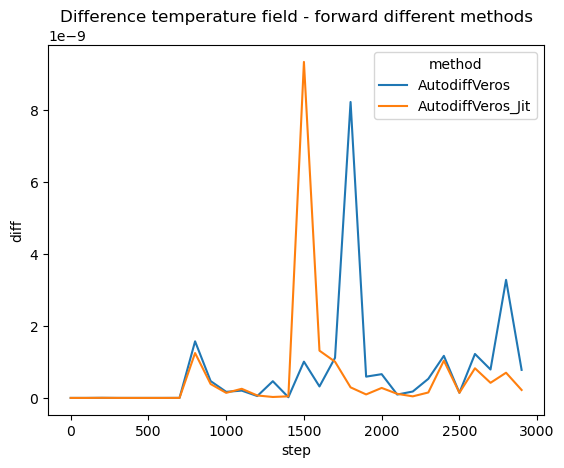

In [11]:
sns.lineplot(stats, x='step', y='diff', hue='method')
plt.title('Difference temperature field - forward different methods')

In [12]:
stats.groupby('method').mean()

,step,diff
method,,
AutodiffVeros,1450.0,7.688696e-10
AutodiffVeros_Jit,1450.0,6.052145e-10
